### State-level Data

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [95]:
testing = pd.read_json('https://jhucoronavirus.azureedge.net/api/v1/testing/daily.json')
testing.shape

(20836, 10)

In [96]:
testing.head()

,date,state,people_viral_positive,tests_viral_positive,tests_viral_negative,encounters_viral_total,tests_viral_total,people_viral_total,tests_combined_total,cases_conf_probable
0,20200306,AK,NaN,NaN,NaN,NaN,8.0,NaN,8.0,NaN
1,20200307,AK,NaN,NaN,NaN,NaN,12.0,NaN,12.0,NaN
2,20200308,AK,NaN,NaN,NaN,NaN,14.0,NaN,14.0,NaN
3,20200309,AK,NaN,NaN,NaN,NaN,23.0,NaN,23.0,NaN
4,20200310,AK,NaN,NaN,NaN,NaN,23.0,NaN,23.0,NaN


In [97]:
testing['date'] = pd.to_datetime(testing.date,format='%Y%m%d')

In [98]:
texas_testing = testing[testing.state=='TX']
texas_testing.reset_index(drop=True,inplace=True)

In [99]:
texas_testing.shape

(371, 10)

In [101]:
texas_testing['Overall Positivity'] = texas_testing.cases_conf_probable/texas_testing.tests_viral_total*100
texas_testing['Overall Positivity Moving Average'] = \
        texas_testing['Overall Positivity'].rolling(7,min_periods=7).mean()
texas_testing['daily_tests'] = texas_testing.tests_viral_total.diff()
texas_testing['daily_positive'] = texas_testing.tests_viral_positive.diff()
texas_testing['daily_positivity_rate'] = texas_testing.daily_positive/texas_testing.daily_tests*100
texas_testing['Rolling Positivity Rate Average'] = \
    texas_testing.daily_positivity_rate.rolling(7,min_periods=7).mean()
texas_testing['rolling_avg_tests'] = texas_testing.daily_tests.rolling(7,min_periods=7).mean()
texas_testing['daily_people_positive'] = texas_testing.cases_conf_probable.diff()
texas_testing['rolling_avg_positives'] = texas_testing.daily_people_positive.rolling(7).mean()
texas_testing['JHU Rolling Positivity Rate'] = texas_testing.rolling_avg_positives/\
            texas_testing.rolling_avg_tests*100
texas_testing['weekly_tests'] = texas_testing.daily_tests.rolling(7,min_periods=7).sum()
texas_testing['weekly_positives'] = texas_testing.daily_positive.rolling(7,min_periods=7).sum()
texas_testing['Rolling Positivity Rate Absolute'] = texas_testing.weekly_positives/texas_testing\
            .weekly_tests*100

<ipython-input-101-943743b7cbc5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texas_testing['Overall Positivity'] = texas_testing.cases_conf_probable/texas_testing.tests_viral_total*100
<ipython-input-101-943743b7cbc5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texas_testing['Overall Positivity Moving Average'] = \
<ipython-input-101-943743b7cbc5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



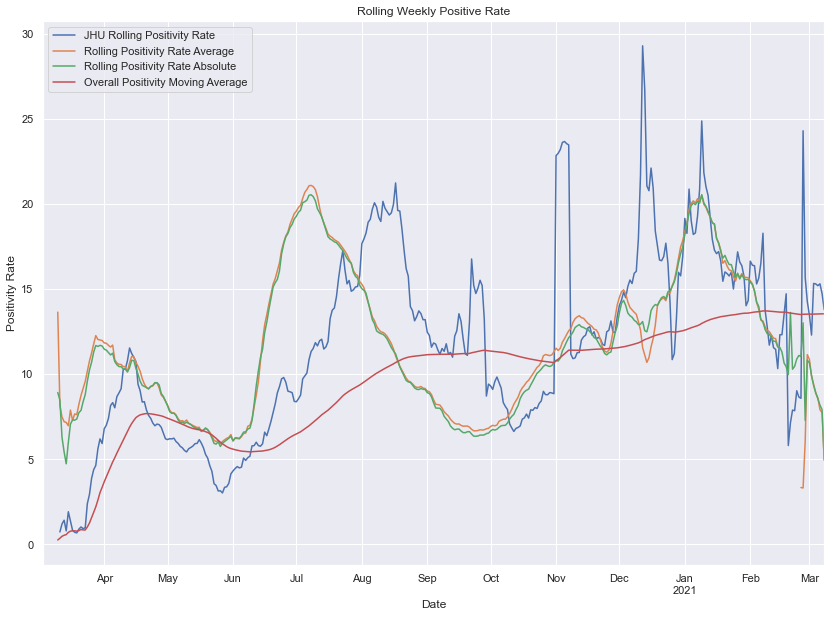

In [105]:
_ = texas_testing[['date','JHU Rolling Positivity Rate','Rolling Positivity Rate Average',
                   'Rolling Positivity Rate Absolute','Overall Positivity Moving Average']]\
    .plot(x='date', figsize=(14,10),
                title='Rolling Weekly Positive Rate', ylabel='Positivity Rate', xlabel='Date')
plt.savefig('PositivityRates.png')

### County-level Testing Data

- Daily tests

In [2]:
county_tests = pd.read_excel('https://dshs.texas.gov/coronavirus/TexasCOVID-19CumulativeTestsbyCounty.xlsx',
               header=1)
county_tests = county_tests.iloc[:254,:]

,County,2020-09-13 00:00:00,2020-09-14 00:00:00,2020-09-15 00:00:00,2020-09-16 00:00:00,2020-09-17 00:00:00,2020-09-18 00:00:00,2020-09-19 00:00:00,2020-09-20 00:00:00,2020-09-21 00:00:00,...,2021-02-27 00:00:00,2021-02-28 00:00:00,2021-03-01 00:00:00,2021-03-02 00:00:00,2021-03-03 00:00:00,2021-03-04 00:00:00,2021-03-05 00:00:00,2021-03-06 00:00:00,2021-03-07 00:00:00,2021-03-08 00:00:00
0,Anderson,26091.0,26113.0,26150.0,26164.0,26223.0,26264.0,26297.0,26325.0,26373,...,54678.0,54795.0,54839.0,54925.0,54996.0,55289.0,55299.0,55650.0,55825.0,55891.0
1,Andrews,1186.0,1187.0,1218.0,1222.0,1237.0,1339.0,1340.0,1341.0,1346,...,6136.0,6142.0,6147.0,6151.0,6160.0,6172.0,6173.0,6243.0,6254.0,6258.0
2,Angelina,14452.0,14503.0,14879.0,14972.0,15089.0,15214.0,15292.0,15429.0,15469,...,69731.0,69818.0,70360.0,70526.0,70648.0,70899.0,70925.0,71730.0,72278.0,72385.0
3,Aransas,1873.0,1875.0,1899.0,1926.0,1957.0,1996.0,2009.0,2023.0,2065,...,13060.0,13079.0,13124.0,13179.0,13258.0,13300.0,13306.0,13591.0,13655.0,13683.0
4,Archer,412.0,412.0,413.0,414.0,426.0,436.0,440.0,443.0,445,...,3582.0,3582.0,3596.0,3599.0,3605.0,3612.0,3614.0,3671.0,3672.0,3677.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,Wood,3940.0,3960.0,3984.0,4046.0,4222.0,4267.0,4285.0,4321.0,4396,...,19582.0,19627.0,19664.0,19710.0,19776.0,19833.0,19840.0,19948.0,20002.0,20035.0
250,Yoakum,932.0,935.0,1000.0,1004.0,1075.0,1161.0,1163.0,1165.0,1175,...,2673.0,2676.0,2681.0,2684.0,2687.0,2691.0,2691.0,2698.0,2700.0,2706.0
251,Young,1821.0,1827.0,1839.0,1841.0,1900.0,1964.0,1974.0,1982.0,1994,...,8216.0,8219.0,8328.0,8341.0,8362.0,8451.0,8462.0,8507.0,8521.0,8534.0
252,Zapata,3281.0,3285.0,3285.0,3288.0,3373.0,3428.0,3470.0,3477.0,3481,...,18452.0,18496.0,18761.0,18786.0,18963.0,19000.0,19000.0,19036.0,19063.0,19089.0


In [3]:
county_level = pd.DataFrame(columns=['Date','daily_tests','County'])
counter = 0
for county in county_tests.County:
    df = pd.DataFrame(county_tests[county_tests.County==county].T.reset_index().iloc[1:]\
        .rename(columns={'index':'Date',counter:'Cumulative Tests'}))
    df['daily_tests'] = df['Cumulative Tests'].diff()
    df['County'] = county
    df.drop(columns=['Cumulative Tests'], inplace=True)
    county_level = county_level.append(df)
    counter += 1
county_level['Date'] = pd.to_datetime(county_level.Date,format='%Y%m%d')
county_level['daily_tests'] = county_level['daily_tests'].fillna(0).astype('int64')

,Date,daily_tests,County
1,2020-09-13,0,Anderson
2,2020-09-14,22,Anderson
3,2020-09-15,37,Anderson
4,2020-09-16,14,Anderson
5,2020-09-17,59,Anderson
...,...,...,...
173,2021-03-04,16,Zavala
174,2021-03-05,1,Zavala
175,2021-03-06,37,Zavala
176,2021-03-07,15,Zavala


In [4]:
county_tests2 = pd.read_excel('https://dshs.texas.gov/coronavirus/TexasCOVID-19CumulativeTestsOverTimebyCounty.xlsx',
             header=1, na_values=['--','-'])
county_tests2 = county_tests2.iloc[:254,:]
df2 = pd.DataFrame(columns=['Date','daily_tests','County'])
counter = 0
for county in county_tests2.County:
    df = pd.DataFrame(county_tests2[county_tests2.County==county].T.reset_index().iloc[1:]\
        .rename(columns={'index':'Date',counter:'Cumulative Tests'}))
    df['daily_tests'] = df['Cumulative Tests'].diff()
    df['County'] = county
    df.drop(columns=['Cumulative Tests'], inplace=True)
    df2 = df2.append(df)
    counter += 1

,Date,daily_tests,County
1,Tests Through April 21,NaN,Anderson
2,Tests Through April 22,12.0,Anderson
3,Tests Through April 23,15.0,Anderson
4,Tests Through April 24,32.0,Anderson
5,Tests Through April 25,8.0,Anderson
...,...,...,...
141,Tests Through September 8,2.0,Zavala
142,Tests Through September 9,10.0,Zavala
143,Tests Through September 10,0.0,Zavala
144,Tests Through September 11,30.0,Zavala


In [5]:
df2['Date'] = df2.Date.str.replace('Tests Through ','')
months = {'April ':'04-','May ':'05-','June ':'06-','July ':'07-','August ':'08-','September ':'09-'}
for k in list(months.keys()):
    df2['Date'] = df2.Date.str.replace(k, months[k])
df2['Date'] = df2.Date.replace(months)
df2['Date'] = [x + '-2020' for x in df2.Date]
df2.dropna(subset=['daily_tests'],inplace=True)
df2['Date'] = pd.to_datetime(df2.Date)
df2['daily_tests'] = df2['daily_tests'].fillna(0).astype('int64')

,Date,daily_tests,County
2,2020-04-22,12,Anderson
3,2020-04-23,15,Anderson
4,2020-04-24,32,Anderson
5,2020-04-25,8,Anderson
6,2020-04-26,0,Anderson
...,...,...,...
141,2020-09-08,2,Zavala
142,2020-09-09,10,Zavala
143,2020-09-10,0,Zavala
144,2020-09-11,30,Zavala


In [6]:
county_level = county_level.append(df2)
county_level.sort_values(by=['County','Date'],inplace=True)
county_level.reset_index(drop=True,inplace=True)
county_level = pd.DataFrame(county_level, columns=['Date','County','daily_tests'])

,Date,County,daily_tests
0,2020-04-22,Anderson,12
1,2020-04-23,Anderson,15
2,2020-04-24,Anderson,32
3,2020-04-25,Anderson,8
4,2020-04-26,Anderson,0
...,...,...,...
80005,2021-03-04,Zavala,16
80006,2021-03-05,Zavala,1
80007,2021-03-06,Zavala,37
80008,2021-03-07,Zavala,15


- Probable positives

In [7]:
county_cases = pd.read_excel('https://dshs.texas.gov/coronavirus/TexasCOVID-19NewProbableCasesbyCounty.xlsx',
               header=2)
county_cases = county_cases.iloc[:254,:]

C:\Users\robin\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:214: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,County,New Probable 2020-11-01,New Probable 2020-11-02,New Probable 2020-11-03,New Probable 2020-11-04,New Probable 2020-11-05,New Probable 2020-11-06,New Probable 2020-11-07,New Probable 2020-11-08,New Probable 2020-11-09,...,New Probable 2021-02-28,New Probable 2021-03-01,New Probable 2021-03-02,New Probable 2021-03-03,New Probable 2021-03-04,New Probable 2021-03-05,New Probable 2021-03-06,New Probable 2021-03-07,New Probable 2021-03-08,New Probable 2021-03-09
0,Anderson,0.0,0.0,6.0,0.0,17.0,24.0,0.0,1.0,0.0,...,0.0,0.0,0.0,11.0,0.0,6.0,0.0,0.0,0.0,-1.0
1,Andrews,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Angelina,0.0,0.0,35.0,0.0,25.0,0.0,0.0,0.0,0.0,...,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aransas,0.0,0.0,0.0,53.0,0.0,2.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0
4,Archer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,Wood,0.0,0.0,0.0,0.0,0.0,39.0,0.0,24.0,0.0,...,0.0,0.0,0.0,10.0,0.0,6.0,0.0,0.0,0.0,2.0
250,Yoakum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,Young,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
252,Zapata,0.0,0.0,0.0,13.0,0.0,1.0,4.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [8]:
county_level2 = pd.DataFrame(columns=['Date','daily_probable','County'])
counter = 0
for county in county_cases.County:
    df = pd.DataFrame(county_cases[county_cases.County==county].T.reset_index().iloc[1:]\
        .rename(columns={'index':'Date',counter:'daily_probable'}))
    df['County'] = county
    county_level2 = county_level2.append(df)
    counter += 1
county_level2['Date'] = county_level2.Date.str.replace('New Probable ','')
county_level2['Date'] = pd.to_datetime(county_level2.Date)
county_level2['daily_probable'] = county_level2['daily_probable'].fillna(0).astype('int64')

,Date,daily_probable,County
1,2020-11-01,0,Anderson
2,2020-11-02,0,Anderson
3,2020-11-03,6,Anderson
4,2020-11-04,0,Anderson
5,2020-11-05,17,Anderson
...,...,...,...
125,2021-03-05,0,Zavala
126,2021-03-06,1,Zavala
127,2021-03-07,0,Zavala
128,2021-03-08,0,Zavala


In [9]:
county_level = county_level.merge(county_level2, how='left', on=['Date','County'])
county_level['daily_probable'] = county_level.daily_probable.fillna(0).astype('int64')

,Date,County,daily_tests,daily_probable
0,2020-04-22,Anderson,12,0
1,2020-04-23,Anderson,15,0
2,2020-04-24,Anderson,32,0
3,2020-04-25,Anderson,8,0
4,2020-04-26,Anderson,0,0
...,...,...,...,...
80005,2021-03-04,Zavala,16,0
80006,2021-03-05,Zavala,1,0
80007,2021-03-06,Zavala,37,1
80008,2021-03-07,Zavala,15,0


- Confirmed positives

In [10]:
county_cases = pd.read_excel('https://dshs.texas.gov/coronavirus/TexasCOVID-19NewCasesOverTimebyCounty.xlsx',
               header=2)
county_cases = county_cases.iloc[:254,:]

C:\Users\robin\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:214: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,County,New Cases 03-04-2020,New Cases 03-05-2020,New Cases 03-06-2020,New Cases 03-09-2020,New Cases 03-10-2020,New Cases 03-11-2020,New Cases 03-12-2020,New Cases 03-13-2020,New Cases 03-15-2020,...,New Cases 02-28-2021,New Cases 03-01-2021,New Cases 03-02-2021,New Cases 03-03-2021,New Cases 03-04-2021,New Cases 03-05-2021,New Cases 03-06-2021,New Cases 03-07-2021,New Cases 03-08-2021,New Cases 03-09-2021
0,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-9.0,3.0,-1.0,7.0,-2.0,0.0,0.0,3.0
1,Andrews,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Angelina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aransas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,11.0,1.0,0.0,4.0,0.0,1.0,0.0,3.0
4,Archer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,Wood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,6.0,0.0,0.0,0.0,6.0
250,Yoakum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,Young,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,-1.0
252,Zapata,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,5.0,1.0,3.0,0.0,2.0,1.0,0.0,1.0


In [12]:
county_level2 = pd.DataFrame(columns=['Date','daily_confirmed','County'])
counter = 0
for county in county_cases.County:
    df = pd.DataFrame(county_cases[county_cases.County==county].T.reset_index().iloc[1:]\
        .rename(columns={'index':'Date',counter:'daily_confirmed'}))
    df['County'] = county
    county_level2 = county_level2.append(df)
    counter += 1
county_level2['Date'] = county_level2.Date.str.replace('New Cases ','')
county_level2['Date'] = pd.to_datetime(county_level2.Date)
county_level2['daily_confirmed'] = county_level2['daily_confirmed'].fillna(0).astype('int64')

,Date,daily_confirmed,County
1,2020-03-04,0,Anderson
2,2020-03-05,0,Anderson
3,2020-03-06,0,Anderson
4,2020-03-09,0,Anderson
5,2020-03-10,0,Anderson
...,...,...,...
364,2021-03-05,0,Zavala
365,2021-03-06,2,Zavala
366,2021-03-07,0,Zavala
367,2021-03-08,0,Zavala


In [13]:
county_level = county_level.merge(county_level2, how='left', on=['Date','County'])

,Date,County,daily_tests,daily_probable,daily_confirmed
0,2020-04-22,Anderson,12,0,4
1,2020-04-23,Anderson,15,0,0
2,2020-04-24,Anderson,32,0,2
3,2020-04-25,Anderson,8,0,0
4,2020-04-26,Anderson,0,0,2
...,...,...,...,...,...
80005,2021-03-04,Zavala,16,0,0
80006,2021-03-05,Zavala,1,0,0
80007,2021-03-06,Zavala,37,1,2
80008,2021-03-07,Zavala,15,0,0


- Positivity rate calculations

In [30]:
county_level['total_positives'] = county_level.daily_probable + county_level.daily_confirmed
county_level['rolling_avg_tests'] = \
    county_level.groupby('County')['daily_tests'].rolling(7).mean().reset_index(drop=True)
county_level['rolling_avg_positives'] = \
    county_level.groupby('County')['total_positives'].rolling(7).mean().reset_index(drop=True)
county_level['JHA Rolling Positivity Rate'] = \
    county_level['rolling_avg_positives']/county_level['rolling_avg_tests']*100

,Date,County,daily_tests,daily_probable,daily_confirmed,total_positives,rolling_avg_tests,rolling_avg_postives,rolling_avg_positives,JHA Rolling Positivity Rate
0,2020-04-22,Anderson,12,0,4,4,NaN,NaN,NaN,NaN
1,2020-04-23,Anderson,15,0,0,0,NaN,NaN,NaN,NaN
2,2020-04-24,Anderson,32,0,2,2,NaN,NaN,NaN,NaN
3,2020-04-25,Anderson,8,0,0,0,NaN,NaN,NaN,NaN
4,2020-04-26,Anderson,0,0,2,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
80005,2021-03-04,Zavala,16,0,0,0,30.857143,2.571429,2.571429,8.333333
80006,2021-03-05,Zavala,1,0,0,0,25.142857,1.857143,1.857143,7.386364
80007,2021-03-06,Zavala,37,1,2,3,22.857143,2.285714,2.285714,10.000000
80008,2021-03-07,Zavala,15,0,0,0,18.857143,1.857143,1.857143,9.848485


In [81]:
import requests, zipfile, io
r = requests.get('https://www.gstatic.com/covid19/mobility/Region_Mobility_Report_CSVs.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(members=['2020_US_Region_Mobility_Report.csv'])

In [82]:
mobility = pd.read_csv('2020_US_Region_Mobility_Report.csv')

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
1,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0
2,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0
3,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0
4,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981595,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,ChIJd4Rqhed3YocR7ubT5-HgoJg,2021-03-01,NaN,NaN,NaN,NaN,-19.0,NaN
981596,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,ChIJd4Rqhed3YocR7ubT5-HgoJg,2021-03-02,NaN,NaN,NaN,NaN,-10.0,NaN
981597,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,ChIJd4Rqhed3YocR7ubT5-HgoJg,2021-03-03,NaN,NaN,NaN,NaN,-20.0,NaN
981598,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,ChIJd4Rqhed3YocR7ubT5-HgoJg,2021-03-04,NaN,NaN,NaN,NaN,-16.0,NaN


In [84]:
texas = mobility[mobility.sub_region_1 == 'Texas']

(72424, 15)

In [87]:
texas['sub_region_2'] = texas.sub_region_2.str.replace(' County', '')

<ipython-input-87-3465e22961c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texas['sub_region_2'] = texas.sub_region_2.str.replace(' County', '')


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
787457,US,United States,Texas,NaN,NaN,US-TX,NaN,ChIJSTKCCzZwQIYRPN4IGI8c6xY,2020-02-15,3.0,3.0,12.0,3.0,1.0,-1.0
787458,US,United States,Texas,NaN,NaN,US-TX,NaN,ChIJSTKCCzZwQIYRPN4IGI8c6xY,2020-02-16,8.0,3.0,20.0,4.0,1.0,-1.0
787459,US,United States,Texas,NaN,NaN,US-TX,NaN,ChIJSTKCCzZwQIYRPN4IGI8c6xY,2020-02-17,6.0,2.0,21.0,2.0,-18.0,4.0
787460,US,United States,Texas,NaN,NaN,US-TX,NaN,ChIJSTKCCzZwQIYRPN4IGI8c6xY,2020-02-18,-1.0,-1.0,-4.0,3.0,1.0,0.0
787461,US,United States,Texas,NaN,NaN,US-TX,NaN,ChIJSTKCCzZwQIYRPN4IGI8c6xY,2020-02-19,-2.0,0.0,-12.0,0.0,3.0,1.0


In [89]:
texas = texas[['sub_region_2','date','retail_and_recreation_percent_change_from_baseline',
              'grocery_and_pharmacy_percent_change_from_baseline',
              'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
              'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']]

,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
787457,NaN,2020-02-15,3.0,3.0,12.0,3.0,1.0,-1.0
787458,NaN,2020-02-16,8.0,3.0,20.0,4.0,1.0,-1.0
787459,NaN,2020-02-17,6.0,2.0,21.0,2.0,-18.0,4.0
787460,NaN,2020-02-18,-1.0,-1.0,-4.0,3.0,1.0,0.0
787461,NaN,2020-02-19,-2.0,0.0,-12.0,0.0,3.0,1.0
...,...,...,...,...,...,...,...,...
859876,Zavala,2021-03-01,NaN,NaN,NaN,NaN,-28.0,NaN
859877,Zavala,2021-03-02,NaN,NaN,NaN,NaN,-24.0,NaN
859878,Zavala,2021-03-03,NaN,NaN,NaN,NaN,-22.0,NaN
859879,Zavala,2021-03-04,NaN,NaN,NaN,NaN,-24.0,NaN


In [91]:
texas.rename(columns={'sub_region_2':'County','date':'Date'},inplace=True)
texas = texas[texas.County.notnull()]
texas['Date'] = pd.to_datetime(texas.Date)

,County,Date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
787843,Anderson,2020-02-15,3.0,1.0,NaN,NaN,-1.0,NaN
787844,Anderson,2020-02-16,7.0,10.0,NaN,NaN,-4.0,NaN
787845,Anderson,2020-02-17,1.0,-3.0,NaN,NaN,-13.0,3.0
787846,Anderson,2020-02-18,2.0,-4.0,NaN,NaN,0.0,0.0
787847,Anderson,2020-02-19,-5.0,-9.0,NaN,NaN,1.0,2.0
...,...,...,...,...,...,...,...,...
859876,Zavala,2021-03-01,NaN,NaN,NaN,NaN,-28.0,NaN
859877,Zavala,2021-03-02,NaN,NaN,NaN,NaN,-24.0,NaN
859878,Zavala,2021-03-03,NaN,NaN,NaN,NaN,-22.0,NaN
859879,Zavala,2021-03-04,NaN,NaN,NaN,NaN,-24.0,NaN


In [93]:
county_level = county_level.merge(texas, how='left', on=['Date','County'])

,Date,County,daily_tests,daily_probable,daily_confirmed,total_positives,rolling_avg_tests,rolling_avg_postives,rolling_avg_positives,JHA Rolling Positivity Rate,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-04-22,Anderson,12,0,4,4,NaN,NaN,NaN,NaN,-29.0,-12.0,NaN,NaN,-31.0,13.0
1,2020-04-23,Anderson,15,0,0,0,NaN,NaN,NaN,NaN,-14.0,-5.0,NaN,NaN,-32.0,9.0
2,2020-04-24,Anderson,32,0,2,2,NaN,NaN,NaN,NaN,-19.0,-2.0,NaN,NaN,-33.0,12.0
3,2020-04-25,Anderson,8,0,0,0,NaN,NaN,NaN,NaN,-22.0,0.0,NaN,NaN,-14.0,NaN
4,2020-04-26,Anderson,0,0,2,2,NaN,NaN,NaN,NaN,-17.0,1.0,NaN,NaN,-18.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80005,2021-03-04,Zavala,16,0,0,0,30.857143,2.571429,2.571429,8.333333,NaN,NaN,NaN,NaN,-24.0,NaN
80006,2021-03-05,Zavala,1,0,0,0,25.142857,1.857143,1.857143,7.386364,NaN,NaN,NaN,NaN,-24.0,NaN
80007,2021-03-06,Zavala,37,1,2,3,22.857143,2.285714,2.285714,10.000000,NaN,NaN,NaN,NaN,NaN,NaN
80008,2021-03-07,Zavala,15,0,0,0,18.857143,1.857143,1.857143,9.848485,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
mobility_counties = list(texas.County.unique())
county_level = county_level[county_level.County.isin(mobility_counties)]

,Date,County,daily_tests,daily_probable,daily_confirmed,total_positives,rolling_avg_tests,rolling_avg_postives,rolling_avg_positives,JHA Rolling Positivity Rate,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-04-22,Anderson,12,0,4,4,NaN,NaN,NaN,NaN,-29.0,-12.0,NaN,NaN,-31.0,13.0
1,2020-04-23,Anderson,15,0,0,0,NaN,NaN,NaN,NaN,-14.0,-5.0,NaN,NaN,-32.0,9.0
2,2020-04-24,Anderson,32,0,2,2,NaN,NaN,NaN,NaN,-19.0,-2.0,NaN,NaN,-33.0,12.0
3,2020-04-25,Anderson,8,0,0,0,NaN,NaN,NaN,NaN,-22.0,0.0,NaN,NaN,-14.0,NaN
4,2020-04-26,Anderson,0,0,2,2,NaN,NaN,NaN,NaN,-17.0,1.0,NaN,NaN,-18.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80005,2021-03-04,Zavala,16,0,0,0,30.857143,2.571429,2.571429,8.333333,NaN,NaN,NaN,NaN,-24.0,NaN
80006,2021-03-05,Zavala,1,0,0,0,25.142857,1.857143,1.857143,7.386364,NaN,NaN,NaN,NaN,-24.0,NaN
80007,2021-03-06,Zavala,37,1,2,3,22.857143,2.285714,2.285714,10.000000,NaN,NaN,NaN,NaN,NaN,NaN
80008,2021-03-07,Zavala,15,0,0,0,18.857143,1.857143,1.857143,9.848485,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
county_level.to_csv('MobilityCovid.csv')